In [ ]:
!pip install numpy scipy soundfile librosa pesq matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp312-cp312-linux_x86_64.whl size=284123 sha256=5e08f8e0f58381a6073c045e73dfef0e7b50c06c8031876b45baf2a8cac0ebc2
  Stored in directory: /root/.cache/pip/wheels/9b/d4/a4/9cf3512534cd47ce4a036d1593ee4013f2bf7509e631a147a3
Successfully built pesq


In [ ]:
# from google.colab import drive
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt



In [ ]:
# drive.mount('/content/drive')
# file_path_1 = '/content/drive/MyDrive/projeto3/audio_fala.wav'
file_path_1 = 'audio_fala.wav'

Mounted at /content/drive


Taxa de Amostragem: 44100 Hz
Número de amostras: 500224
Duração: 11.34 segundos


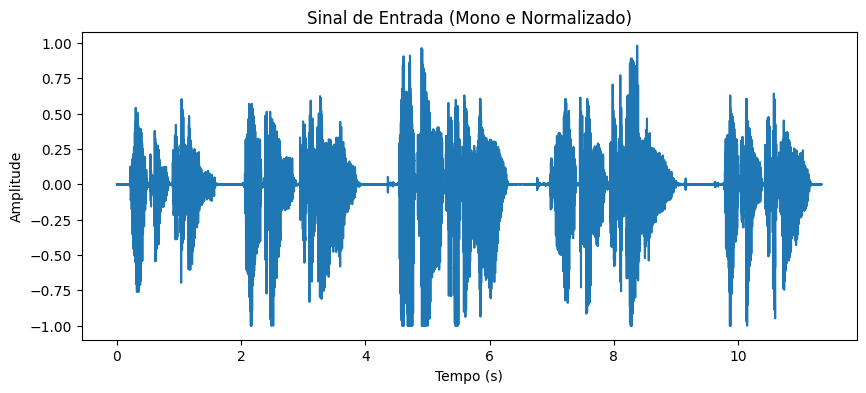

In [ ]:
try:
    audio, samplerate = librosa.load(file_path_1, sr=None, mono=True)

    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val

    print(f"Taxa de Amostragem: {samplerate} Hz")
    print(f"Número de amostras: {len(audio)}")
    print(f"Duração: {len(audio)/samplerate:.2f} segundos")

    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(audio)/samplerate, len(audio)), audio)
    plt.title("Sinal de Entrada (Mono e Normalizado)")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.show()
except FileNotFoundError:
    print(f"O arquivo não foi encontrado no caminho: {file_path}")

    #o audio é alguem falando em inglês "welcome to the bayou" várias vezes.

In [1]:
import numpy as np
from scipy.fftpack import dct
import scipy.signal
import matplotlib.pyplot as plt

# Configuração dos Parâmetros
N = 1024            # Tamanho da janela (frame size)
H = N // 2          # Hop size (Passo) = 50% de sobreposição
block_size = N

# Criação da Janela de Ponderação
# do PDF do relatorio : Aplicar janela de ponderação (Hann)
# A janela suaviza as bordas do bloco para evitar cliques.
window = scipy.signal.windows.hann(N)

# Pré-processamento (Padding)
# Precisamos garantir que o áudio tenha tamanho múltiplo do Hop
# ou pelo menos permita extrair o último frame completo.
pad_length = N - (len(audio) % H)
audio_padded = np.pad(audio, (0, pad_length), mode='constant')

print(f"Áudio original: {len(audio)} amostras")
print(f"Áudio com padding: {len(audio_padded)} amostras")

# Laço de Processamento (Framing + Transformada)
# Vamos armazenar os coeficientes espectrais em uma lista
dct_coefficients = []

num_frames = (len(audio_padded) - N) // H
print(f"Processando {num_frames} quadros...")

for i in range(num_frames):
    # Definir início e fim do quadro atual
    start = i * H
    end = start + N

    # Extrair o quadro (slicing)
    frame = audio_padded[start:end]

    # Aplicar a Janela de Ponderação
    frame_windowed = frame * window

    # Aplicar Transformada (DCT-IV)
    # type=4 é a DCT-IV.
    frame_transf = dct(frame_windowed, type=4, norm='ortho')

    dct_coefficients.append(frame_transf)


# Formato final: [Número de Frames, 1024 Coeficientes]
dct_coefficients = np.array(dct_coefficients)

print(f"Shape dos coeficientes: {dct_coefficients.shape}")
# Ex: (978, 1024) significa 978 quadros, cada um com 1024 bandas de frequência.


#plotamr o log da energia
plt.figure(figsize=(12, 6))
plt.imshow(20 * np.log10(np.abs(dct_coefficients.T) + 1e-9),
           aspect='auto', origin='lower', cmap='inferno')
plt.title("Espectrograma (Coeficientes da DCT-IV)")
plt.ylabel("Frequência (Bins)")
plt.xlabel("Tempo (Frames)")
plt.colorbar(label="Magnitude (dB)")
plt.show()

NameError: name 'audio' is not defined

In [ ]:
from scipy.fftpack import idct

In [ ]:
def reconstruir_audio(coeficientes, N, H, length_original):
    """
    Reconstroi o áudio a partir dos coeficientes DCT-IV.
    """
    # Estimamos o tamanho baseado no número de frames
    num_frames = coeficientes.shape[0]
    output_size = num_frames * H + N
    reconstructed_signal = np.zeros(output_size)

    # Recriar a mesma janela usada no passo anterior
    window = scipy.signal.windows.hann(N)


    for i in range(num_frames):
        # Pegar os coeficientes do quadro atual
        frame_freq = coeficientes[i, :]

        # Transformada Inversa (IDCT-IV)
        frame_time = idct(frame_freq, type=4, norm='ortho')

        # Aplicar a Janela novamente (Síntese)
        frame_windowed = frame_time * window

        # Overlap-Add
        start = i * H
        end = start + N
        reconstructed_signal[start:end] += frame_windowed

    # Cortar o padding extra que adicionamos no começo
    return reconstructed_signal[:length_original]

audio_rec_perfeito = reconstruir_audio(dct_coefficients, N, H, len(audio))

sf.write('rec_perfeito.wav', audio_rec_perfeito, 44100)

In [ ]:


def quantizacao_baseline(coeficientes, delta):
    if delta == 0:
        return coeficientes, coeficientes # Bypass

    # quantizar (Indices Inteiros)
    indices = np.round(coeficientes / delta)

    # dequantizar (Reconstrução)
    coeficientes_recuperados = indices * delta

    return coeficientes_recuperados, indices




delta_teste = 0.05
coeffs_baseline, indices = quantizacao_baseline(dct_coefficients, delta_teste)

audio_baseline = reconstruir_audio(coeffs_baseline, N, H, len(audio))
sf.write('audio_baseline.wav', audio_baseline, 44100)

In [ ]:
def hz2bark(f):
    """
    Converte frequência (Hz) para bark (z) usando a fórmula de Traunmüller (1990)
    Formula: z = [26.81 / (1 + 1960/f)] - 0.53
    """
    # evitar divisao por zero para f=0
    f = np.maximum(f, 1e-6)
    z = (26.81 / (1 + (1960 / f))) - 0.53

    # Escala bark não é definida para menor que zero
    return np.maximum(0, z)

def bark2hz(z):
    """
    Inverso da fórmula Traunmüller
    Derivation:
      z + 0.53 = 26.81 / (1 + 1960/f)
      1 + 1960/f = 26.81 / (z + 0.53)
      1960/f = (26.81 / (z + 0.53)) - 1
      f = 1960 / [ (26.81 / (z + 0.53)) - 1 ]
    """
    denom = (26.81 / (z + 0.53)) - 1

    # não deixar z ser alto demais (fora da escala de frequência)
    with np.errstate(divide='ignore', invalid='ignore'):
        f = 1960 / denom

    f = np.nan_to_num(f, nan=0.0, posinf=44100.0)
    return np.maximum(0, f)

def criar_bandas_bark(sample_rate, num_bins, num_bandas=20):
    """
    Cria limites de bandas baseados na escala Bark de Traunmüller.

    Args:
        sample_rate (int): Taxa de amostragem (ex: 44100).
        num_bins (int): Número de bins de frequência disponíveis (tamanho do array ).
        num_bandas (int): Quantidade desejada de bandas Bark.

    Returns:
        list: Lista de tuplas (inicio, fim) com os índices dos bins.
    """
    max_freq = sample_rate / 2.0

    # calcular o range Bark total (0 Hz até Nyquist)
    max_bark = hz2bark(max_freq)

    # criar pontos linearmente espaçados no domínio Bark
    bark_points = np.linspace(0, max_bark, num_bandas + 1)

    # cnverter esses pontos de volta para Hertz
    freq_points = bark2hz(bark_points)

    # converter Hertz para índices de Bin
    # Bin index = (freq / nyquist) * total_bins
    # assumindo que num_bins cobre de 0 a sample_rate/2
    indices = np.floor(freq_points / max_freq * num_bins).astype(int)

    # limpeza e garantias de integridade
    indices = np.unique(indices) # Remove duplicatas (comum em baixas freqs com poucos bins)
    indices = np.clip(indices, 0, num_bins)

    # forçar o primeiro e último bin para cobrir tudo
    if indices[0] != 0:
        indices = np.insert(indices, 0, 0)
    if indices[-1] != num_bins:
        indices = np.append(indices, num_bins)

    # criar lista de tuplas (inicio, fim)
    bandas = []
    for i in range(len(indices) - 1):
        bandas.append((indices[i], indices[i+1]))

    return bandas


# CODEC a seguir segue exatamente o que foi pedido no roteiro: mais bits alocados para região de mais energia "bandas mais energéticas recebem mais resolução"

def quantizacao_perceptual(coeficientes, bandas, fator_qualidade=1.0):
    coeffs_recuperados = np.zeros_like(coeficientes)

    # Armazenaremos os indices apenas para calculo de entropia
    indices_acumulados = []

    global_energy_mean = np.mean(coeficientes**2)
    energy_floor = global_energy_mean * 1e-4

    num_frames = coeficientes.shape[0]

    for i in range(num_frames):
        frame = coeficientes[i, :]

        for (inicio, fim) in bandas:
            if inicio >= fim: continue

            sub_banda = frame[inicio:fim]
            energia = np.mean(sub_banda ** 2)
            energia_safe = max(energia, energy_floor)

            # expoente pequeno na filtragem perceptual para não destruir as bandas
            # de baixa energia
            weight = np.power(energia_safe, 0.2)

            delta_banda = fator_qualidade / (weight + 1e-9)

            # manter delta entre 1 e 0.00001 para evitar problemas
            delta_banda = max(min(delta_banda, 1.0), 1e-5)

            # Quantização
            indices_q = np.round(sub_banda / delta_banda)

            # Reconstrução
            sub_banda_rec = indices_q * delta_banda

            coeffs_recuperados[i, inicio:fim] = sub_banda_rec
            indices_acumulados.append(indices_q)

    all_indices = np.concatenate(indices_acumulados)

    return coeffs_recuperados, all_indices


sample_rate = 44100
N_fft = 1024
fator_q = 0.05

bandas_bark = criar_bandas_bark(sample_rate, N_fft, num_bandas=25)

coeffs_perceptual, all_indices = quantizacao_perceptual(dct_coefficients, bandas_bark, fator_q)

audio_perceptual = reconstruir_audio(coeffs_perceptual, N, H, len(audio))
sf.write('audio_perceptual.wav', audio_perceptual, 44100)

print(f"Bandas geradas: {len(bandas_bark)}")
print(f"Exemplo da primeira banda (bins): {bandas_bark[0]}")
print(f"Exemplo da última banda (bins): {bandas_bark[-1]}")



# Referencia:
# Traunmüller, H. (1990). "Analytical expressions for the tonotopic sensory scale".
# The Journal of the Acoustical Society of America. 88 (1): 97–100.

Bandas geradas: 101
Exemplo da primeira banda (bins): (np.int64(0), np.int64(1))
Exemplo da última banda (bins): (np.int64(913), np.int64(1024))


In [ ]:
def generate_test_signals(duration_sec=3.0, sample_rate=44100):
    """
    gera senóide e ruído branco para teste do codec
    """
    t = np.linspace(0, duration_sec, int(sample_rate * duration_sec), endpoint=False)

    # senóide (440 Hz)
    freq = 440.0
    sine_wave = np.sin(2 * np.pi * freq * t)

    sine_wave = sine_wave / np.max(np.abs(sine_wave))

    white_noise = np.random.uniform(-1, 1, len(t))

    white_noise = white_noise / np.max(np.abs(white_noise))

    sf.write('test_sine.wav', sine_wave, sample_rate)
    sf.write('test_noise.wav', white_noise, sample_rate)


generate_test_signals()

In [ ]:
!pip install lameenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 5.8 MB/s eta 0:00:00


In [ ]:
import lameenc


def encode_with_lame(audio_data, sample_rate=44100, quality=5, target_bitrate=128):
    """
    Encodes float audio data using the LAME encoder for comparison.

    Args:
        audio_data: Numpy array (float32, -1.0 to 1.0)
        sample_rate: Hz
        quality: 0 (Highest/Slowest) to 9 (Lowest/Fastest). 5 is standard good VBR.
    """
    encoder = lameenc.Encoder()
    encoder.set_bit_rate(target_bitrate)
    encoder.set_in_sample_rate(sample_rate)
    encoder.set_channels(1)
    encoder.set_quality(quality)   # 2=High, 5=Medium, 7=Fast

    # LAME expects 16-bit PCM integer data, not floats
    # Convert float [-1, 1] -> int16 [-32768, 32767]
    audio_int16 = (audio_data * 32767).clip(-32768, 32767).astype(np.int16)

    # Encode
    mp3_data = encoder.encode(audio_int16.tobytes())
    mp3_data += encoder.flush()

    return mp3_data


# áudio original (sem quantização)
audio_original = audio

# versão LAME
mp3_binary = encode_with_lame(audio, sample_rate=44100, quality=2)

with open("referencia_lame.mp3", "wb") as f:
    f.write(mp3_binary)

print(f"LAME MP3 gerado. Tamanho: {len(mp3_binary)} bytes")

LAME MP3 gerado. Tamanho: 182230 bytes


In [ ]:
def calcular_bitrate(indices_quantizados, sample_rate, num_amostras_original):
    simbolos = indices_quantizados.flatten()
    total_simbolos = len(simbolos)

    _, contagens = np.unique(simbolos, return_counts=True)
    probabilidades = contagens / total_simbolos

    # entropia de Shannon
    entropia = -np.sum(probabilidades * np.log2(probabilidades))

    bits_totais = entropia * total_simbolos
    duracao_segundos = num_amostras_original / sample_rate

    return (bits_totais / duracao_segundos) / 1000.0, entropia

In [ ]:


def encontrar_parametro_ideal(funcao_quantizacao, coeffs_originais, bitrate_alvo,
                              sample_rate, num_amostras, args_extras=None,
                              tolerancia=0.05, max_iter=20):
    p_min = 1e-5
    p_max = 100.0
    melhor_param = p_min
    melhor_erro = float('inf')
    bitrate_final = 0

    for i in range(max_iter):
        p_meio = (p_min + p_max) / 2

        # quantizar
        if args_extras:
            coeffs_q, indices_q = funcao_quantizacao(coeffs_originais, args_extras, p_meio)
        else:
            coeffs_q, indices_q = funcao_quantizacao(coeffs_originais, p_meio)

        # calcular bitrate
        kbps_calc, _ = calcular_bitrate(indices_q, sample_rate, num_amostras)

        erro = abs(kbps_calc - bitrate_alvo)

        if erro < melhor_erro:
            melhor_erro = erro
            melhor_param = p_meio
            bitrate_final = kbps_calc

        if erro / bitrate_alvo < tolerancia:
            break

        # lógica de pesquisa binária para achar o bitrate ideal e comparar justamente
        if kbps_calc > bitrate_alvo:
            # Bitrate muito alto -> reduzir delta ou fator de qualidade -> Reduzir qualidade
            p_min = p_meio
        else:
            p_max = p_meio

    print(f"Iterações: {i+1} | Bitrate: {bitrate_final:.2f} kbps | Param: {melhor_param:.4f}")
    return melhor_param


targets = [64, 96, 128] # kbps
resultados = []


# LOOP BASELINE
for target in targets:
    delta_opt = encontrar_parametro_ideal(
        quantizacao_baseline, dct_coefficients, target, sample_rate, len(audio)
    )

    coeffs_final, _ = quantizacao_baseline(dct_coefficients, delta_opt)

    audio_rec = reconstruir_audio(coeffs_final, N, H, len(audio))
    nome_arq = f"baseline_{target}kbps.wav"
    sf.write(nome_arq, audio_rec, sample_rate)
    resultados.append(("Baseline", target, delta_opt, nome_arq))

# LOOP PERCEPTUAl
bandas_bark = criar_bandas_bark(sample_rate, N, num_bandas=25) # 25 bandas bark aqui

for target in targets:
    fator_opt = encontrar_parametro_ideal(
        quantizacao_perceptual, dct_coefficients, target, sample_rate, len(audio), args_extras=bandas_bark
    )

    coeffs_final, _ = quantizacao_perceptual(dct_coefficients, bandas_bark, fator_opt)

    audio_rec = reconstruir_audio(coeffs_final, N, H, len(audio))
    nome_arq = f"perceptual_{target}kbps.wav"
    sf.write(nome_arq, audio_rec, sample_rate)
    resultados.append(("Perceptual", target, fator_opt, nome_arq))

# LOOP LAME

for target in targets:
    mp3_data = encode_with_lame(audio, sample_rate=44100, target_bitrate=target)

    nome_mp3 = f"lame_{target}kbps.mp3"
    with open(nome_mp3, "wb") as f:
        f.write(mp3_data)

    audio_rec_lame, _ = librosa.load(nome_mp3, sr=sample_rate)

    if len(audio_rec_lame) != len(audio):
        min_len = min(len(audio), len(audio_rec_lame))
        audio_rec_lame = audio_rec_lame[:min_len]

    nome_wav_lame = f"lame_{target}kbps_decoded.wav"
    sf.write(nome_wav_lame, audio_rec_lame, sample_rate)

    resultados.append(("LAME", target, target, nome_wav_lame))

print(f"{'Modo':<12} | {'Alvo (kbps)':<12} | {'Parâmetro Otimizado':<20} | {'Arquivo'}")
print("-" * 65)
for modo, alvo, param, arq in resultados:
    print(f"{modo:<12} | {alvo:<12} | {param:<20.5f} | {arq}")

Iterações: 15 | Bitrate: 65.28 kbps | Param: 0.0153
Iterações: 16 | Bitrate: 94.44 kbps | Param: 0.0076
Iterações: 16 | Bitrate: 121.67 kbps | Param: 0.0046
Iterações: 15 | Bitrate: 65.76 kbps | Param: 0.0031
Iterações: 18 | Bitrate: 96.84 kbps | Param: 0.0012
Iterações: 19 | Bitrate: 126.05 kbps | Param: 0.0006
Modo         | Alvo (kbps)  | Parâmetro Otimizado  | Arquivo
-----------------------------------------------------------------
Baseline     | 64           | 0.01527              | baseline_64kbps.wav
Baseline     | 96           | 0.00764              | baseline_96kbps.wav
Baseline     | 128          | 0.00459              | baseline_128kbps.wav
Perceptual   | 64           | 0.00306              | perceptual_64kbps.wav
Perceptual   | 96           | 0.00115              | perceptual_96kbps.wav
Perceptual   | 128          | 0.00058              | perceptual_128kbps.wav
LAME         | 64           | 64.00000             | lame_64kbps_decoded.wav
LAME         | 96           | 96.000

In [ ]:
import pandas as pd

Avaliando: baseline_64kbps.wav ...
Avaliando: baseline_96kbps.wav ...
Avaliando: baseline_128kbps.wav ...
Avaliando: perceptual_64kbps.wav ...
Avaliando: perceptual_96kbps.wav ...
Avaliando: perceptual_128kbps.wav ...
Avaliando: lame_64kbps_decoded.wav ...
Avaliando: lame_96kbps_decoded.wav ...
Avaliando: lame_128kbps_decoded.wav ...
      Modo  Bitrate Alvo  SNR (dB)  PESQ (MOS)                  Arquivo
  Baseline            64     10.18       2.946      baseline_64kbps.wav
  Baseline            96     10.18       3.177      baseline_96kbps.wav
  Baseline           128     10.18       3.268     baseline_128kbps.wav
Perceptual            64     10.17       2.664    perceptual_64kbps.wav
Perceptual            96     10.18       3.057    perceptual_96kbps.wav
Perceptual           128     10.18       3.194   perceptual_128kbps.wav
      LAME            64     -2.76       4.527  lame_64kbps_decoded.wav
      LAME            96     -2.75       4.618  lame_96kbps_decoded.wav
      LAME      

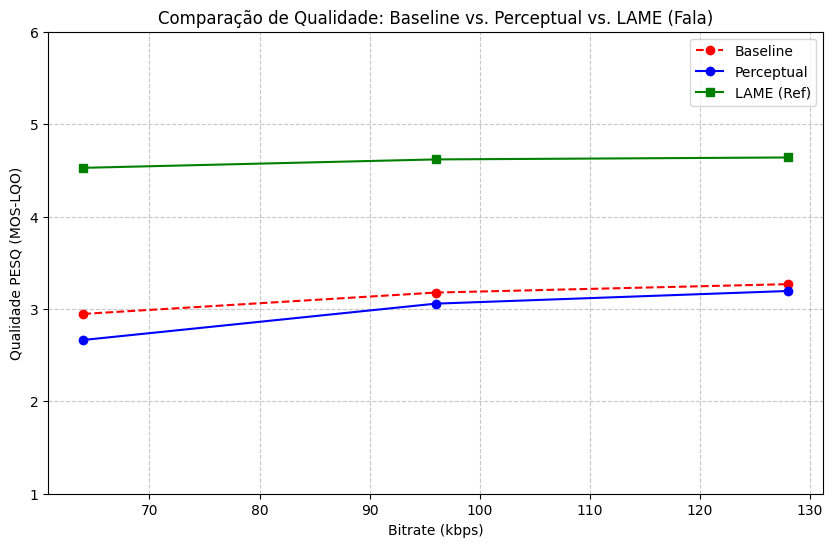

In [ ]:

from pesq import pesq



def calcular_snr(referencia, degradado):
    """
    Calcula a relação Sinal-Ruído em dB.
    SNR = 10 * log10(Potencia_Sinal / Potencia_Ruido)
    """

    min_len = min(len(referencia), len(degradado))
    ref = referencia[:min_len]
    deg = degradado[:min_len]


    ruido = ref - deg

    potencia_sinal = np.sum(ref ** 2)
    potencia_ruido = np.sum(ruido ** 2)

    if potencia_ruido == 0:
        return float('inf') # Reconstrução perfeita

    snr = 10 * np.log10(potencia_sinal / potencia_ruido)
    return snr


# O PESQ exige referência e teste em 16kHz (Wideband)


audio_ref_16k = librosa.resample(audio, orig_sr=44100, target_sr=16000)


dados_avaliacao = []


for modo, alvo_kbps, param, nome_arquivo in resultados:
    print(f"Avaliando: {nome_arquivo} ...")

    # carregar o áudio processado (Degradado)
    # Ler em 44.1kHz para SNR
    audio_deg, _ = librosa.load(nome_arquivo, sr=44100)


    # comparar o degradado carregado com o original 'audio'
    snr_val = calcular_snr(audio, audio_deg)

    # pesq 16kHz
    try:
        # resample do degradado para 16kHz
        audio_deg_16k = librosa.resample(audio_deg, orig_sr=44100, target_sr=16000)

        # alinhar tamanhos (PESQ não rola com arrays de tamanhos diferentes)
        min_len_16k = min(len(audio_ref_16k), len(audio_deg_16k))
        ref_trim = audio_ref_16k[:min_len_16k]
        deg_trim = audio_deg_16k[:min_len_16k]

        # executar PESQ (Wideband)
        pesq_score = pesq(16000, ref_trim, deg_trim, 'wb')

    except Exception as e:
        print(f"  Erro no PESQ para {nome_arquivo}: {e}")
        pesq_score = np.nan

    dados_avaliacao.append({
        "Modo": modo,
        "Bitrate Alvo": alvo_kbps,
        "SNR (dB)": round(snr_val, 2),
        "PESQ (MOS)": round(pesq_score, 3),
        "Arquivo": nome_arquivo
    })

df_resultados = pd.DataFrame(dados_avaliacao)


print(df_resultados.to_string(index=False))


plt.figure(figsize=(10, 6))

baseline = df_resultados[df_resultados["Modo"] == "Baseline"]
perceptual = df_resultados[df_resultados["Modo"] == "Perceptual"]
lame_ref = df_resultados[df_resultados["Modo"] == "LAME"] # Novo filtro

plt.plot(baseline["Bitrate Alvo"], baseline["PESQ (MOS)"], 'o--', label="Baseline", color='red')
plt.plot(perceptual["Bitrate Alvo"], perceptual["PESQ (MOS)"], 'o-', label="Perceptual", color='blue')
plt.plot(lame_ref["Bitrate Alvo"], lame_ref["PESQ (MOS)"], 's-', label="LAME (Ref)", color='green') # Nova linha

plt.xlabel("Bitrate (kbps)")
plt.ylabel("Qualidade PESQ (MOS-LQO)")
plt.title("Comparação de Qualidade: Baseline vs. Perceptual vs. LAME (Fala)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(1.0, 6)
plt.show()

Iterações: 15 | Bitrate: 37.81 kbps | Param: 0.0031
Iterações: 15 | Bitrate: 37.81 kbps | Param: 0.0031
Iterações: 15 | Bitrate: 37.81 kbps | Param: 0.0031
Iterações: 15 | Bitrate: 24.99 kbps | Param: 0.0031
Iterações: 15 | Bitrate: 24.99 kbps | Param: 0.0031
Iterações: 15 | Bitrate: 24.99 kbps | Param: 0.0031

Calculando métricas para test_sine.wav...
Iterações: 11 | Bitrate: 65.82 kbps | Param: 1.0254
Iterações: 7 | Bitrate: 98.45 kbps | Param: 0.7813
Iterações: 9 | Bitrate: 129.09 kbps | Param: 0.5859
Iterações: 15 | Bitrate: 69.10 kbps | Param: 50.0000
Iterações: 11 | Bitrate: 94.12 kbps | Param: 0.5371
Iterações: 8 | Bitrate: 128.83 kbps | Param: 0.3906

Calculando métricas para test_noise.wav...


 RESULTADOS FINAIS (Sinais Sintéticos)
             Sinal        Modo  Bitrate        SNR      PESQ
0    test_sine.wav    Baseline       64  10.179843  2.105018
1    test_sine.wav    Baseline       96  10.179843  2.105018
2    test_sine.wav    Baseline      128  10.179843  2.105018
3   

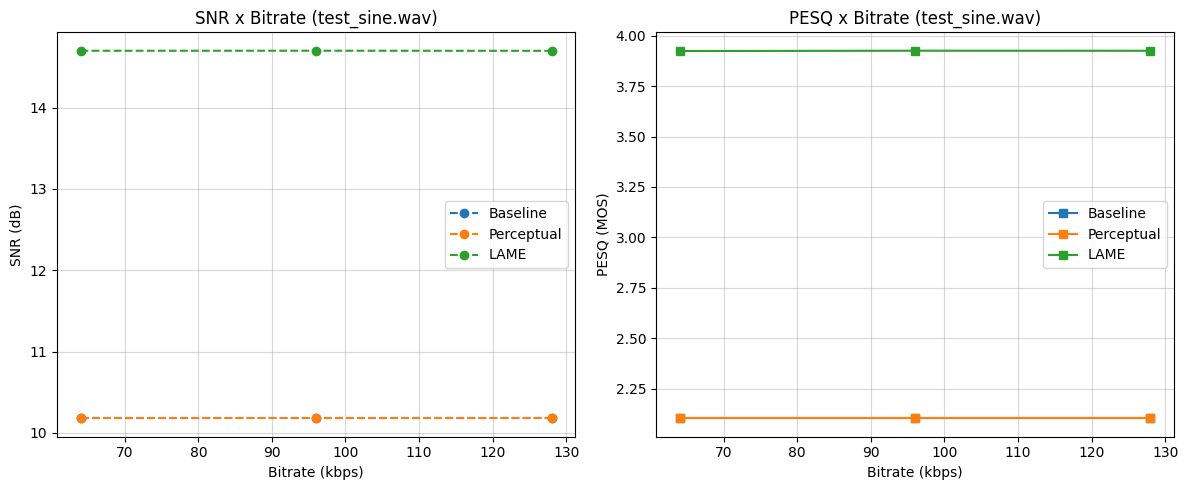

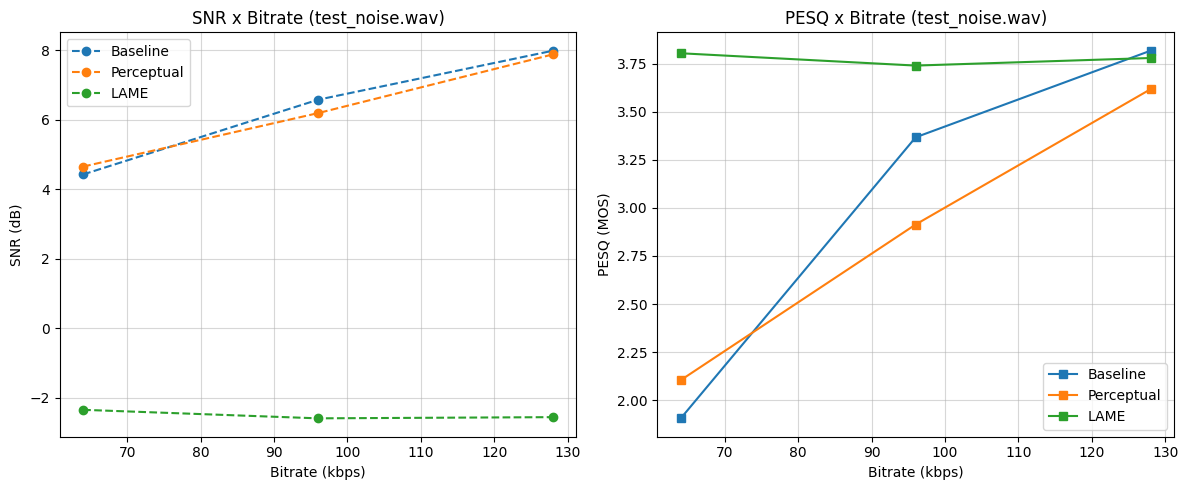

In [ ]:
test_files = ['test_sine.wav', 'test_noise.wav']
targets = [64, 96, 128]


todos_resultados_sinteticos = []

for file_name in test_files:



    audio_sint, sr_sint = librosa.load(file_name, sr=None, mono=True)


    max_val = np.max(np.abs(audio_sint))
    if max_val > 0:
        audio_sint = audio_sint / max_val

    # calcular dct (Necessário refazer pois 'dct_coefficients' era da fala)
    # reutilizando N e H definidos anteriormente
    window = scipy.signal.windows.hann(N)
    pad_length = N - (len(audio_sint) % H)
    audio_padded = np.pad(audio_sint, (0, pad_length), mode='constant')

    coeffs_sint = []
    num_frames = (len(audio_padded) - N) // H

    for i in range(num_frames):
        start = i * H
        end = start + N
        frame = audio_padded[start:end] * window
        frame_transf = dct(frame, type=4, norm='ortho')
        coeffs_sint.append(frame_transf)

    coeffs_sint = np.array(coeffs_sint)

    # estrutura para salvar resultados deste arquivo
    resultados_arquivo = []

    for target in targets:
        delta_opt = encontrar_parametro_ideal(
            quantizacao_baseline, coeffs_sint, target, sr_sint, len(audio_sint),
            max_iter=15 # iterar menos para ser mais rapido
        )
        c_final, _ = quantizacao_baseline(coeffs_sint, delta_opt)
        audio_rec = reconstruir_audio(c_final, N, H, len(audio_sint))

        fname = f"base_{file_name[:-4]}_{target}k.wav"
        sf.write(fname, audio_rec, sr_sint)
        resultados_arquivo.append(("Baseline", target, fname))


    # Recalcular bandas para garantir (embora sr seja 44100 igual)
    bandas_bark_sint = criar_bandas_bark(sr_sint, N, num_bandas=25)

    for target in targets:
        fator_opt = encontrar_parametro_ideal(
            quantizacao_perceptual, coeffs_sint, target, sr_sint, len(audio_sint),
            args_extras=bandas_bark_sint, max_iter=15
        )
        c_final, _ = quantizacao_perceptual(coeffs_sint, bandas_bark_sint, fator_opt)
        audio_rec = reconstruir_audio(c_final, N, H, len(audio_sint))

        fname = f"perc_{file_name[:-4]}_{target}k.wav"
        sf.write(fname, audio_rec, sr_sint)
        resultados_arquivo.append(("Perceptual", target, fname))

    # CODEC LAME
    for target in targets:
        mp3_data = encode_with_lame(audio_sint, sample_rate=sr_sint, target_bitrate=target)
        fname_mp3 = f"lame_{file_name[:-4]}_{target}k.mp3"
        with open(fname_mp3, "wb") as f:
            f.write(mp3_data)

        audio_lame, _ = librosa.load(fname_mp3, sr=sr_sint)
        if len(audio_lame) != len(audio_sint):
            m = min(len(audio_sint), len(audio_lame))
            audio_lame = audio_lame[:m]

        fname_wav = f"lame_{file_name[:-4]}_{target}k_dec.wav"
        sf.write(fname_wav, audio_lame, sr_sint)
        resultados_arquivo.append(("LAME", target, fname_wav))

    # (SNR e PESQ)
    print(f"\nCalculando métricas para {file_name}...")

    # Referência para PESQ (16kHz)
    try:
        ref_16k = librosa.resample(audio_sint, orig_sr=sr_sint, target_sr=16000)
    except:
        ref_16k = None

    for modo, target, fpath in resultados_arquivo:
        deg, _ = librosa.load(fpath, sr=sr_sint)

        # SNR
        snr_val = calcular_snr(audio_sint, deg)

        # PESQ
        pesq_score = np.nan
        if ref_16k is not None:
            try:
                deg_16k = librosa.resample(deg, orig_sr=sr_sint, target_sr=16000)
                min_len = min(len(ref_16k), len(deg_16k))
                # PESQ pode falhar em tons puros/ruído pois é feito para voz
                pesq_score = pesq(16000, ref_16k[:min_len], deg_16k[:min_len], 'wb')
            except Exception:
                pesq_score = np.nan

        todos_resultados_sinteticos.append({
            "Sinal": file_name,
            "Modo": modo,
            "Bitrate": target,
            "SNR": snr_val,
            "PESQ": pesq_score
        })

df_sint = pd.DataFrame(todos_resultados_sinteticos)

print("\n\n RESULTADOS FINAIS (Sinais Sintéticos)")
print(df_sint.to_string())

# Plotagem
sinais_unicos = df_sint["Sinal"].unique()

for sinal in sinais_unicos:
    df_temp = df_sint[df_sint["Sinal"] == sinal]

    plt.figure(figsize=(12, 5))

    # Gráfico SNR
    plt.subplot(1, 2, 1)
    for modo in ["Baseline", "Perceptual", "LAME"]:
        subset = df_temp[df_temp["Modo"] == modo]
        if not subset.empty:
            plt.plot(subset["Bitrate"], subset["SNR"], 'o--', label=modo)
    plt.title(f"SNR x Bitrate ({sinal})")
    plt.xlabel("Bitrate (kbps)")
    plt.ylabel("SNR (dB)")
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Gráfico PESQ (literalmente irrelevante para senoide)
    plt.subplot(1, 2, 2)
    for modo in ["Baseline", "Perceptual", "LAME"]:
        subset = df_temp[df_temp["Modo"] == modo]
        if not subset.empty:
            plt.plot(subset["Bitrate"], subset["PESQ"], 's-', label=modo)
    plt.title(f"PESQ x Bitrate ({sinal})")
    plt.xlabel("Bitrate (kbps)")
    plt.ylabel("PESQ (MOS)")
    plt.legend()
    plt.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()